# Initialization

In [1]:
!nvidia-smi

Wed Apr  7 08:36:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 205 (delta 16), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (205/205), 62.72 KiB | 10.45 MiB/s, done.
Resolving deltas: 100% (78/78), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Kaggle Data

In [ ]:
# Download data and move to Google Drive
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c shopee-product-matching
!mv shopee-product-matching.zip ./drive/MyDrive/data/

In [4]:
# Copy from Google Drive and unzip
!cp ./drive/MyDrive/data/shopee-product-matching.zip ./
!unzip -q shopee-product-matching.zip
!rm shopee-product-matching.zip

!cp ./drive/MyDrive/data/universal-sentence-encoder-cmlm_multilingual-preprocess_2.tar.gz ./
!cp ./drive/MyDrive/data/2.tar.gz ./
!mkdir preprocessor
!mkdir labse_model
!tar -xf universal-sentence-encoder-cmlm_multilingual-preprocess_2.tar.gz -C ./preprocessor
!tar -xf 2.tar.gz -C ./labse_model
!rm universal-sentence-encoder-cmlm_multilingual-preprocess_2.tar.gz 2.tar.gz

## Import Packages

In [ ]:
!pip install tensorflow_text
!pip install spacy
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from cuml.neighbors import NearestNeighbors
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.cluster import DBSCAN
import gc
import pandas as pd
import numpy as np
import cudf, cuml, cupy
import pickle
import matplotlib.pyplot as plt
import random
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE = 32
CHUNK_SIZE = 4096
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
LIMIT = 8.0
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

if physical_devices:
    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0], [
            tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=1024 * LIMIT)
        ])
    print('TensorFlow usage is restricted to max %iGB GPU RAM' % LIMIT)

Num GPUs: 1
TensorFlow usage is restricted to max 8GB GPU RAM


# Process Data

In [7]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
#     image /= 255  # normalize to [0,1] rangeI'm not a 
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augmentation(ds):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
      layers.experimental.preprocessing.RandomRotation(0.3),
      layers.experimental.preprocessing.RandomTranslation(
          height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
      layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])
    
    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x: data_augmentation(x))

    # Prefecting on all datasets
    return ds.prefetch(1)

def prepare_data(df, augment=False):
    # Load images
    path_ds = tf.data.Dataset.from_tensor_slices(df['image_paths'])
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = augmentation(image_ds)
    else:
        ds = image_ds.batch(BATCH_SIZE).prefetch(1)
    
    return ds

In [89]:
load_dir = os.getcwd()
# Load and process images
df_train = pd.read_csv(load_dir + '/train.csv')
df_train['image_paths'] = load_dir + '/train_images/' + df_train['image'] 

# Ground truth
tmp = df_train.groupby('label_group').posting_id.agg('unique').to_dict()
df_train['target'] = df_train.label_group.map(tmp)

# Duplicate train set for runtime testing 
# df_train = pd.concat([df_train, df_train], ignore_index=True)
train_ds = prepare_data(df_train, augment=False)

# Embeddings

In [9]:
class SimilarSearch:
    """
    Finding the similar embeddings with NearestNeighbors or Cosine similarity.
    Dynamically learning the threshold for each item with DBSCAN.
    RAPIDS.AI accelerated.
    """
    def __init__(self, k=50):
        self.CHUNK_SIZE = 4096 
        self.k = k
        self.MIN_SAMPLES = 1

    @staticmethod
    def dbscan_cluster(dbscan, idx, dist, strict=False):
        """
        Figure out number of similar items by excluding the last cluster.

        Parameters:
            dbscan: DBSCAN model
            idx: index of nearest items
            dist: distance between items 
        Returns:
            index: index of similar items
        """
        dbscan.fit(dist.reshape(-1, 1))
        labels = dbscan.labels_
    
        if strict:
            counts = len(labels[labels==0])
        else:
            counts = len(
                labels[:labels.argmax()]) if labels.max() != 0 else len(labels)
        
        similar_item_index = idx[:counts].tolist()
        
        return similar_item_index

    def nearest_neighbors(self, embeddings, min_dist, verbose=True):
        """
        Get the k nearest items.

        Parameters:
            embeddings: embeddings of images
            min_dist: the maximum distance between two samples (DBSCAN)
            verbose: wether to print out chunk verbose
        Returns:
            item_index: indexes of similar items
        """
        knn = NearestNeighbors(n_neighbors=self.k)
        knn.fit(embeddings)
        dbscan = DBSCAN(eps=min_dist, min_samples=self.MIN_SAMPLES)

        num_chunk = round(embeddings.shape[0] / self.CHUNK_SIZE)
        item_index = []
        for i in range(num_chunk + 1):
            start_idx = i * self.CHUNK_SIZE
            end_idx = min((i + 1) * self.CHUNK_SIZE, embeddings.shape[0])
            if verbose:
                print('Chunk', start_idx, 'to', end_idx)

            dist, idx = knn.kneighbors(embeddings[start_idx:end_idx, :])
            for j in range(end_idx - start_idx):
                index = self.dbscan_cluster(dbscan, idx[j], dist[j])
                item_index.append(index)

        return item_index

    def cosine_similarity(self, embeddings, threshold, verbose=True):
        """
        Get similar items with cosine similarity, applicable for unit vectors.
        """
        num_chunk = round(embeddings.shape[0] / self.CHUNK_SIZE)
        item_index = []
        for i in range(num_chunk + 1):
            start_idx = i * self.CHUNK_SIZE                  
            end_idx = min((i + 1) * self.CHUNK_SIZE, embeddings.shape[0])
            if verbose:
                print('Chunk', start_idx, 'to', end_idx) 
            
            cos_sim = cupy.matmul(embeddings, embeddings[start_idx:end_idx].T).T
            for j in range(end_idx - start_idx):
                idx = cupy.where(cos_sim[j] > threshold)[0]
                item_index.append(cupy.asnumpy(idx))

        return item_index

sim = SimilarSearch(k=50)

## Image Embedding

In [10]:
# Image embedding
effnet = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)
embeddings_image = effnet.predict(train_ds, verbose=1)

del effnet
_ = gc.collect()

1071/1071 [==============================] - 69s 56ms/step


In [11]:
print(f"Image Similarity Search:")
image_index = sim.nearest_neighbors(embeddings_image, 1.2)

del embeddings_image
_ = gc.collect()

Image Similarity Search:
Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250


## Text Embedding

In [87]:
preprocessor = hub.KerasLayer("./preprocessor")
encoder = hub.KerasLayer("./labse_model")

In [104]:
tpp = TextPreProcess(df_train.title)
title_ds = tf.data.Dataset.from_tensor_slices(tpp.sentences)
title_ds = title_ds.batch(BATCH_SIZE)
title_ds = title_ds.map(lambda x: preprocessor(x))
title_ds = title_ds.cache().prefetch(AUTOTUNE)

In [92]:
inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(None, ), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(None, ), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(None, ), dtype=tf.int32),
)

labert = encoder(inputs)['default']
model = tf.keras.Model(inputs, labert, name='embeddings')

In [105]:
embeddings_text = model.predict(title_ds, verbose=1)

1071/1071 [==============================] - 161s 150ms/step


In [106]:
def normalization(embeds):
  norms = cupy.linalg.norm(embeds, 2, axis=1, keepdims=True)
  return embeds/norms

embeddings_text = normalization(cupy.array(embeddings_text))

In [204]:
# Text embedding
# cudf_train = cudf.DataFrame(df_train)
# sentences = cudf_train.title
sentences = cudf.Series(tpp.sentences)
vectorizer = TfidfVectorizer(binary=True, max_features=20000)
embeddings_text = vectorizer.fit_transform(sentences).toarray()

del sentences, vectorizer
_ = gc.collect()

text_index = sim.cosine_similarity(embeddings_text, 0.73)

Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250


In [107]:
print(f"Text Similarity Search:")
text_index = sim.cosine_similarity(embeddings_text, 0.8)

# del embeddings_text
# _ = gc.collect()

Text Similarity Search:
Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250


# Evaluation

In [205]:
def row_wise_f1_score(y_true, y_pred):

    y_true = y_true.apply(lambda x: set(x))
    y_pred = y_pred.apply(lambda x: set(x))

    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = y_pred.apply(lambda x: len(x)).values - tp
    fn = y_true.apply(lambda x: len(x)).values - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1


def evaluation(df_data, image_index, text_index):
    df_data['matches'] = [
        set(df_data['posting_id'][text].tolist() +
            df_data['posting_id'][image].tolist())
        for text, image in zip(text_index, image_index)
    ]

    df_data['f1'] = row_wise_f1_score(df_data['target'], df_data['matches'])
    return df_data['f1'].mean()


print('f1-score:', evaluation(df_train, image_index, text_index))

f1-score: 0.7495511528314194


- baseline: 0.7299 without preprocessing text
- 0.7345 remove emoji code, content in() / []

# Parameter Tunning

In [98]:
def parameter_tuning(df_data, embeddings_text, image_index, 
                     threshold):
  
    text_index = sim.cosine_similarity(embeddings_text, threshold, verbose=False)
    f1_score = evaluation(df_data, image_index, text_index)
    print('threshold_text: {}, f1-score: {}'.format(
        round(threshold, 2), round(f1_score, 4)))

    return f1_score

In [100]:
results = {}
for i in np.arange(.76, 0.9, .01):
    f1 = parameter_tuning(df_train, embeddings_text, image_index, i)
    results[round(i,2)] = f1

print('The best thresholds is {}, yield a f1-score of {}'.format(max(results, key=results.get), max(results.values())))

threshold_text: 0.76, f1-score: 0.7214
threshold_text: 0.77, f1-score: 0.7248
threshold_text: 0.78, f1-score: 0.7275
threshold_text: 0.79, f1-score: 0.7292
threshold_text: 0.8, f1-score: 0.7299
threshold_text: 0.81, f1-score: 0.7298
threshold_text: 0.82, f1-score: 0.7299
threshold_text: 0.83, f1-score: 0.7288
threshold_text: 0.84, f1-score: 0.7276
threshold_text: 0.85, f1-score: 0.7254
threshold_text: 0.86, f1-score: 0.7231
threshold_text: 0.87, f1-score: 0.7207
threshold_text: 0.88, f1-score: 0.7181
threshold_text: 0.89, f1-score: 0.7159
threshold_text: 0.9, f1-score: 0.7133
The best thresholds is 0.82, yield a f1-score of 0.7299325923677349


# Results Inspection

In [ ]:
def results_inspection(df_train, df_example, col_name):

    df_target = df_train[df_train.posting_id.isin(df_example[col_name])] 
    print('Number of items:', len(df_target))
    print(df_target.title.values)
    n_img = len(df_target)
    n_cols = 5 if n_img >= 5 else n_img
    n_rows = n_img // n_cols if n_cols <5 else (n_img // n_cols) + 1

    plt.figure(figsize=(10, 10))
    for i, image_path, in enumerate(df_target['image_paths']):
        image = tf.io.read_file(image_path)
        image = preprocess_image(image) / 255
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image)
    plt.show()

df_train['image_matches'] = [df_train['posting_id'][image].tolist() for image in image_index]
df_train['text_matches'] = [df_train['posting_id'][text].tolist() for text in text_index]

df_perfect = df_train[df_train.f1==1]
print('Number of perfect matches:', len(df_perfect))
df_bad = df_train[df_train.f1 < 0.7]
print('Number of bad matches:', len(df_bad))

Number of perfect matches: 10379
Number of bad matches: 16303


## Good Match Example

Ground Truth:
Number of items: 2
['Gery Salut Malkist Bag' 'Gery Saluut Malkist Kelapa Family Pack 105 gr']


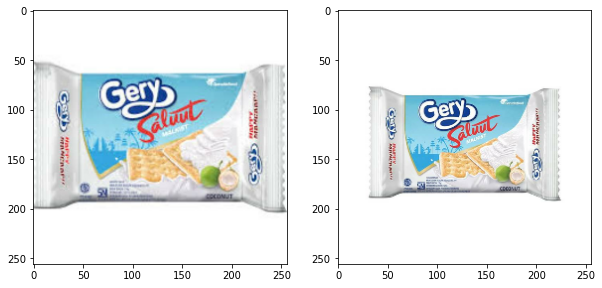

Image Embeddings:
Number of items: 2
['Gery Salut Malkist Bag' 'Gery Saluut Malkist Kelapa Family Pack 105 gr']


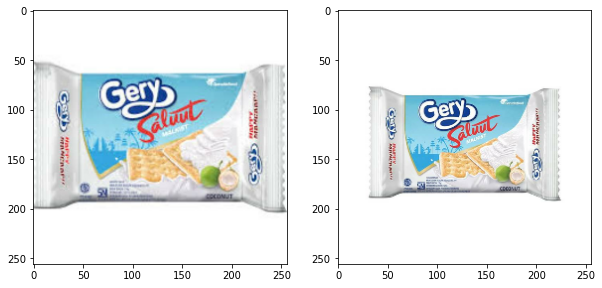

Text Embeddings:
Number of items: 1
['Gery Salut Malkist Bag']


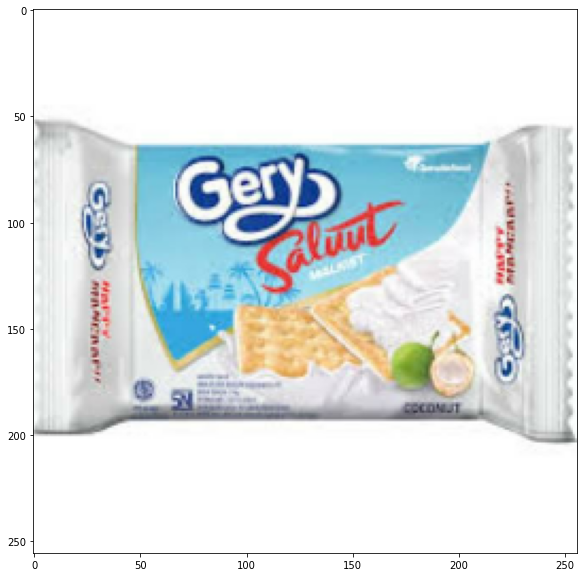

In [ ]:
df_example = df_perfect.iloc[random.randint(0, len(df_perfect))] # index: 33119
print('Ground Truth:')
results_inspection(df_train, df_example, 'target')
print('Image Embeddings:')
results_inspection(df_train, df_example, 'image_matches')
print('Text Embeddings:')
results_inspection(df_train, df_example, 'text_matches')

## Bad Match Example

Ground Truth:
Number of items: 6
['Gabag / Kolibri Breastmilk Storage Bag ASI Love Story Blue Pink 100 ml 100ml Mix 120ml 120 ml 150ml'
 'Gabag Kolibri Love Story Kantong ASI [100 mL]'
 'JVK - GabaG Kantong ASI Love Story 100ml Isi 30 pcs - Breastmilk Storage'
 'Kolibri Smart - Gabag Kantong ASI Love Story 100 ML'
 'GABAG - Kantong ASI Love Story 100 ML'
 'Kantong asi GABAG 100ml (Love story edition)']


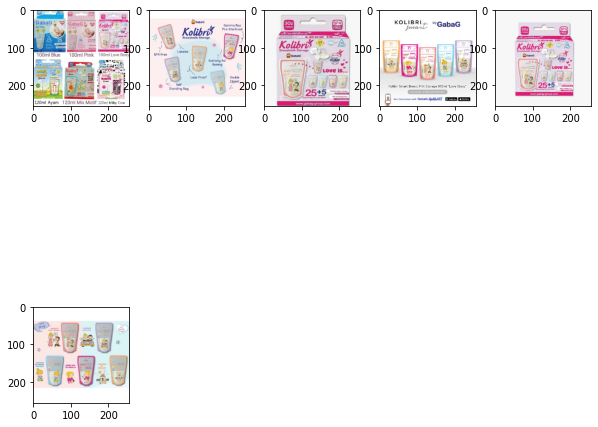

Image Embeddings:
Number of items: 2
['JVK - GabaG Kantong ASI Love Story 100ml Isi 30 pcs - Breastmilk Storage'
 'GABAG - Kantong ASI Love Story 100 ML']


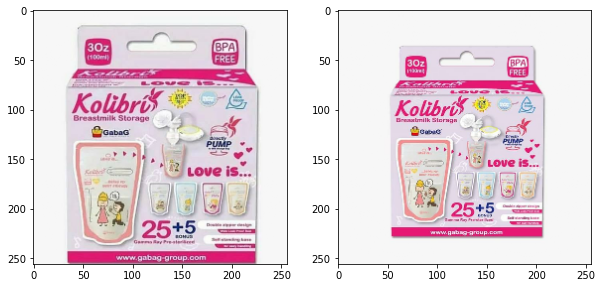

Text Embeddings:
Number of items: 2
['Gabag Kolibri Love Story Kantong ASI [100 mL]'
 'GABAG - Kantong ASI Love Story 100 ML']


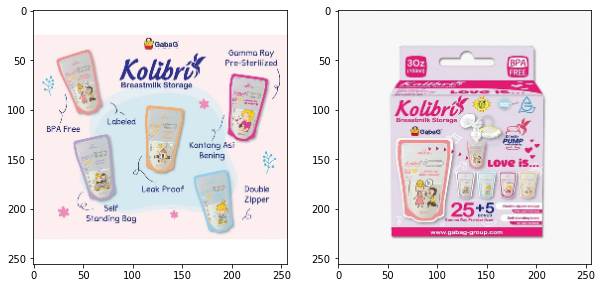

In [ ]:
df_example = df_bad.iloc[random.randint(0, len(df_bad))]
print('Ground Truth:')
results_inspection(df_train, df_example, 'target')
print('Image Embeddings:')
results_inspection(df_train, df_example, 'image_matches')
print('Text Embeddings:')
results_inspection(df_train, df_example, 'text_matches')

# Test Preprocessing

In [222]:
class TextPreProcess:
    def __init__(self, sentences):
        self.sentences = sentences
        self.lower_sentences()
        self.remove_stop_words()
        self.remove_bad_chars()
        self.remove_parenthesized_content()
        self.remove_punctuation()
        self.split_number_unit()
        # self.remove_numbers()
        self.remove_duplicate_words()
        # self.remove_short_words()

    def lower_sentences(self):
        self.sentences = [s.lower() for s in self.sentences]
    
    def remove_stop_words(self):
        stopset = set(stopwords.words(['english', 'german', 'indonesian']))
        def execute_remove(sentence, stopset):
            sentence = ' '.join([word for word in sentence.split() if word not in stopset])
            return sentence
        
        self.sentences = [execute_remove(s, stopset) for s in self.sentences]

    def remove_bad_chars(self):
        # Remove characters e.g. \\xc3\\x89
        self.sentences = [re.sub(r'\\x[a-z0-9]{2}', ' ', s) for s in self.sentences]

    def remove_parenthesized_content(self):
        # Remove contect in () or []
        self.sentences = [re.sub(r'\[[^)]*\]|\([^)]*\)', ' ', s) for s in self.sentences]

    def split_number_unit(self):
        def perform_split(s):
            # Find number with string eg. '100ml'
            t = re.findall(r'\ \d+[a-z]+', s)
            # Remove space
            t = [i.strip() for i in t]
            # Split number and unit
            t_ = [' '.join(list(re.match('([0-9]+)([a-zA-Z]+)', i).groups())) for i in t]
            # Replace character in sentence
            for i in range(len(t)):
                s = s.replace(t[i], t_[i]) 
            return s

        self.sentences = [perform_split(s) for s in self.sentences]

    def remove_punctuation(self):
        self.sentences = [s.translate(str.maketrans('', '', string.punctuation)) for s in self.sentences]

    def remove_numbers(self):
        self.sentences = [re.sub('\d+', ' ', s) for s in self.sentences]

    def remove_duplicate_words(self):
        self.sentences = [' '.join(sorted(set(s.split()), key=s.split().index)) for s in self.sentences]

    def remove_short_words(self):
        self.sentences = [' '.join([word for word in s.split() if len(word) > 2]) for s in self.sentences]

In [223]:
text_example = [
 'GABAG - Kantong ASI Love Story 100 ML',
 'Gabag / Kolibri Breastmilk Storage Bag ASI Love Story Blue Pink 100 ml 100ml Mix 120ml 120 ml 150ml',
 'Gabag Kolibri Love Story Kantong ASI [100 mL]',
 'JVK - GabaG Kantong ASI Love Story 100ml Isi 30 pcs - Breastmilk Storage',
 'Kolibri Smart - Gabag Kantong ASI Love Story 100 ML',
 'Kantong asi GABAG 100ml (Love story edition)'
]
tpp = TextPreProcess(text_example)

In [ ]:
def normalization(embeds):
    norms = np.linalg.norm(embeds, 2, axis=1, keepdims=True)
    return embeds/norms

eg_embeds = encoder(preprocessor(tpp.sentences))['default']
eg_embeds = normalization(eg_embeds)
print (np.matmul(eg_embeds, np.transpose(eg_embeds)))

In [86]:
eg_embeds_tifid = vectorizer.fit_transform(cudf.Series(text_example)).toarray()
print (cupy.matmul(eg_embeds_tifid, eg_embeds_tifid.T).T)

[[0.99999994 0.34283823 0.88625157 0.30251554 0.73658824 0.4986789 ]
 [0.34283823 1.0000001  0.4014415  0.30323237 0.3336492  0.24252859]
 [0.88625157 0.4014415  1.0000001  0.26810482 0.8311278  0.4419549 ]
 [0.30251554 0.30323237 0.26810482 0.9999999  0.22282937 0.366854  ]
 [0.73658824 0.3336492  0.8311278  0.22282937 0.99999994 0.367321  ]
 [0.4986789  0.24252859 0.4419549  0.366854   0.367321   0.9999999 ]]


In [ ]:
title = df_train.title.tolist()
sentences = lower_sentences(title)
sentences = remove_bad_chars(sentences)
sentences = remove_parenthesized_content(sentences)
sentences = remove_punctuation(sentences)
sentences = remove_numbers(sentences)
sentences = remove_duplicate_words(sentences)
sentences = remove_short_words(sentences)

In [ ]:
eg_idx = [random.randint(0, len(title)) for i in range(50)]
print(np.array(title)[eg_idx])

['ENSURE RASA VANILA/ COKELAT 900gram PROMOO'
 'PEMBESAR LAYAR HP / ENLARGE SCREEN MAGNIFIER STAND'
 'GARNIER COLOR NATURALS SACHET'
 '[IMPORT] - Dispenser 2 Tabung Tempat Sabun Cair Shampo Cuci Tangan Mandi (DOUBLE)'
 'Top Living Pel Lantai Putar Otomatis Spin Mop  - 20081'
 'Party popper /confetti (khusus wil. Jawa timur)'
 'BRASOV 50 Ml Original Parfum BPOM'
 'Sale! Premium Block Besar MR. BLOCK isi 106, 136, 176, 236 pcs'
 'Tao Kae Noi Hi Tempura Original 25 gr'
 'Sasa Bumbu Lumur Ayam Spesial 26 gr'
 'Molina Kaftan / YADITA SPARKLE KAFTAN / KEANU DIAMOND KAFTAN / Talisha Kaftan'
 'LCD FULLSET TOUCHSCREEN SAMSUNG G610 / GALAXY J7 PRIME KONTRAS'
 'Riyadhus Shalihin - Darul Haq' '365+ MUG kaca bening uk 24 CL'
 '3M VHB 12mm x 4.5m Double Tape Foam Merah Otomotif & Building ORI'
 'Perfect Bright Tone Up Cream Wardah'
 '1KG MUAT 7PCS | GEYSA PANTS / CELANA STRADI / CELANA SALUR SELEBGRAM'
 'Masker organik by Poupeepou 25g[ FREE KUAS PEMBELIAN 5 PCS ]'
 'Helo Piyama - Baju Tidur Stelan 

In [ ]:
print(np.array(sentences)[eg_idx])

['ensure rasa vanila cokelat gram promoo'
 'pembesar layar enlarge screen magnifier stand'
 'garnier color naturals sachet'
 'dispenser tabung tempat sabun cair shampo cuci tangan mandi'
 'top living pel lantai putar otomatis spin mop' 'party popper confetti'
 'brasov original parfum bpom' 'sale premium block besar isi pcs'
 'tao kae noi tempura original' 'sasa bumbu lumur ayam spesial'
 'molina kaftan yadita sparkle keanu diamond talisha'
 'lcd fullset touchscreen samsung galaxy prime kontras'
 'riyadhus shalihin darul haq' 'mug kaca bening'
 'vhb double tape foam merah otomotif building ori'
 'perfect bright tone cream wardah'
 'muat pcs geysa pants celana stradi salur selebgram'
 'masker organik poupeepou'
 'helo piyama baju tidur stelan kaos anak cewek putri'
 'mycreate hydrating spray' 'set sendok garpu sumpit travel makan jerami'
 'lampu lilin elektrik led tanpa api mini menyala warna natal'
 'strip gula atocheck glucose autocheck darah'
 'baju wanita husna dress navy grosir musl

In [ ]:
cache = set(stopwords.words(['english', 'indonesian', 'german']))
title = df_train.title.tolist()
sentences = [' '.join(word for word in sentence.split() if word not in cache) for sentence in title]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(title)
sequences = tokenizer.texts_to_sequences(title)
sentences = tokenizer.sequences_to_texts(sequences)